In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm

from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud, STOPWORDS

import joblib

In [27]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [28]:
df.shape

(5572, 5)

In [29]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [30]:
df.isna().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [31]:
df = df[['v2', 'v1']]

In [32]:
df.head()

,v2,v1
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham


In [33]:
df['v1'].value_counts()

ham     4825
spam     747
Name: v1, dtype: int64

In [34]:
df_analysis = pd.get_dummies(df, columns=['v1'])

In [35]:
df_analysis.head()

,v2,v1_ham,v1_spam
0,"Go until jurong point, crazy.. Available only ...",1,0
1,Ok lar... Joking wif u oni...,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,0,1
3,U dun say so early hor... U c already then say...,1,0
4,"Nah I don't think he goes to usf, he lives aro...",1,0


In [36]:
wc = WordCloud(stopwords=set(list(STOPWORDS) + ['inside']), random_state=42)

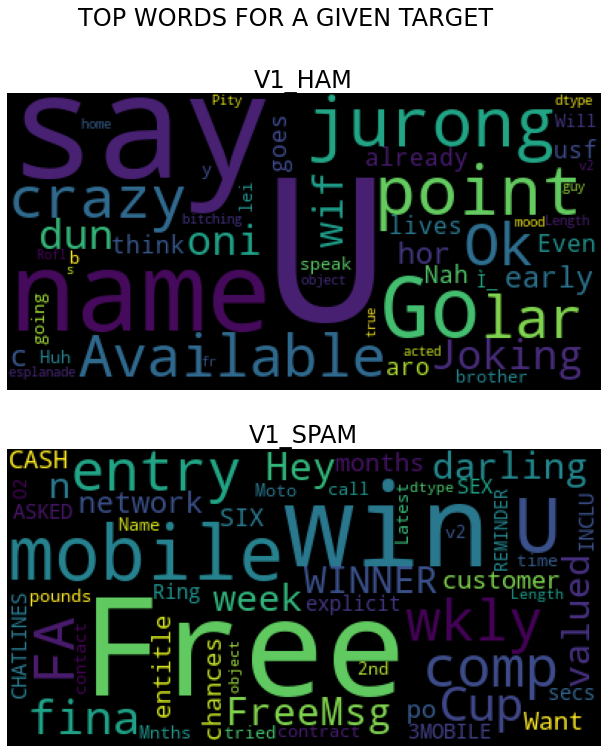

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(20,12))
for i, targs in enumerate(['v1_ham', 'v1_spam']):
    is_target  = df_analysis[df_analysis[targs] == 1]
    op = wc.generate(str(is_target['v2']))
    _= axes[i].imshow(op)
    _= axes[i].set_title(targs.upper(), fontsize=24)
    _= axes[i].axis('off')
_= plt.suptitle('TOP WORDS FOR A GIVEN TARGET', fontsize=24)

In [41]:
train, test = train_test_split(df, test_size=0.3, stratify=df['v1'])

In [45]:

tokenizer = TweetTokenizer()
pipe = Pipeline([("tfidf",TfidfVectorizer(tokenizer=tokenizer.tokenize)),
                ("svm",svm.SVC())])


parameters = {"tfidf__ngram_range" : [(1,2),(2,3)]
                  ,"tfidf__max_df":[0.5,0.8,0.95],
                  "tfidf__min_df":[1,2],
                  "tfidf__analyzer":["word"],
                  'svm__kernel':['rbf',"linear"],
                  'svm__C':[10,100,1000,10000]}
clf = GridSearchCV(pipe, parameters,cv=10,n_jobs=-1,verbose=1,scoring="f1_macro")
clf.fit(train.v2, train.v1)
clf.best_score_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 20.0min finished


0.9756662932456853

In [46]:
print(classification_report(y_pred=clf.best_estimator_.predict(test.v2),y_true=test.v1))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.98      0.93      0.95       224

    accuracy                           0.99      1672
   macro avg       0.98      0.96      0.97      1672
weighted avg       0.99      0.99      0.99      1672



In [47]:
joblib.dump(clf.best_estimator_,"model.sav")

['model.sav']